# Procgen-PPO-RND implementation

PPO-RND implemenetation for the environemnts in the procgen benchmark.

In [1]:
import gym
from gym.wrappers import GrayScaleObservation
from gym.wrappers import FrameStack
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import backend as K
from collections import deque
import random
from matplotlib import pyplot as plt
from threading import Thread
import math

# change keras setting to use the conv2d NN passing the channel first (as returned from the FrameStack wrapper)
K.set_image_data_format('channels_first')

## Memory

Class used to memorize the trajectories and calculate the advantages

In [2]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    EXTRINSIC_REWARD = 3
    INTRINSIC_REWARD = 4
    DONE = 5
    
    def __init__(self, n_trajectories, e_gamma = 0.95, i_gamma = 0.95, e_lambda = 0.999, i_lambda = 0.99, discount_rate = 0.99):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.e_gamma = e_gamma
        self.i_gamma = i_gamma
        self.e_lambda = e_lambda
        self.i_lambda = i_lambda
        
        self.discount_rate = discount_rate
              
    def collect(self, state, action, action_prob, extrinsic_reward, intrinsic_reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, extrinsic_reward, intrinsic_reward, done))
        
    def calculate_advantages(self, reward_standard_deviation_estimate):
        advantages = []
        extrinsic_TDresiduals = []
        intrinsic_TDresiduals = []
        extrinsic_discounts = []
        intrinsic_discounts = []
        
        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            e_delta = []
            i_delta = []
            e_G = []
            i_G = []

            old_v_e_t = ppo.return_v_extrinsic_values(trajectory[-1][self.STATE])
            v_e_t = ppo.return_v_extrinsic_values(trajectory[-2][self.STATE] )
            
            e_delta.append(trajectory[-2][self.EXTRINSIC_REWARD] + 
                           self.e_gamma*old_v_e_t - v_e_t)
            e_G.append(trajectory[-2][self.EXTRINSIC_REWARD] + self.discount_rate*trajectory[-1][self.EXTRINSIC_REWARD])
            e_old_advantage = e_delta[-1]
            
            old_v_e_t = v_e_t
            
            old_v_i_t = ppo.return_v_intrinsic_values(trajectory[-1][self.STATE])
            v_i_t = ppo.return_v_intrinsic_values(trajectory[-2][self.STATE] )
            #normalizing the intrinisc reward before calculating the advantage
            i_delta.append( (trajectory[-2][self.INTRINSIC_REWARD]/ reward_standard_deviation_estimate) + 
                           self.e_gamma*old_v_i_t - v_i_t )
            i_G.append((trajectory[-2][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate) + self.discount_rate*(trajectory[-1][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate))
            i_old_advantage = i_delta[-1]
            
            old_v_i_t = v_i_t
            
            advantage_trajectory.append(e_old_advantage[0] + i_old_advantage[0])
            
            for i in range(len(trajectory)-3,-1,-1):
                v_e_t = ppo.return_v_extrinsic_values(trajectory[i][self.STATE])
                e_delta.append(trajectory[i][self.EXTRINSIC_REWARD] + 
                               self.e_gamma*old_v_e_t - v_e_t)
                e_G.append(trajectory[i][self.EXTRINSIC_REWARD] + self.discount_rate*e_G[-1])
                e_old_advantage = e_delta[-1] + self.e_gamma*self.e_lambda*e_old_advantage                                    
                 
                old_v_e_t = v_e_t
                
                normalized_intrinsic_reward = trajectory[i][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate
                v_i_t = ppo.return_v_intrinsic_values(trajectory[i][self.STATE])
                i_delta.append(normalized_intrinsic_reward + 
                               self.i_gamma*old_v_i_t - v_i_t)
                
                i_G.append(normalized_intrinsic_reward + self.discount_rate*i_G[-1])
                i_old_advantage = i_delta[-1] + self.i_gamma*self.i_lambda*i_old_advantage                                    
                  
                old_v_i_t = v_i_t
                
                advantage_trajectory.append(i_old_advantage[0] + e_old_advantage[0])  
        
                                                                                                                                                                       
            extrinsic_TDresiduals.append(e_delta)
            intrinsic_TDresiduals.append(i_delta)
            
            extrinsic_discounts.append(e_G)
            intrinsic_discounts.append(i_G)
                           
            advantages.append(advantage_trajectory)
            
        #flat all trajectories in a single deque adding the advantages (easier to sample random batches)
        self.flat_trajectories(self.trajectories, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_discounts, intrinsic_discounts)
    
    def flat_trajectories(self, trajectories, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_G, intrinsic_G):
        
        size = 0
        for trajectory in trajectories:
            size = size + len(trajectory)
        
        self.flatten_trajectories = deque(maxlen=size)
        
        for trajectory, advantage, e_delta, i_delta, e_discount, i_discount in zip(trajectories, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_G, intrinsic_G):
            len_trajectory = len(trajectory)
            for i in range(len_trajectory-2,-1,-1):
                self.flatten_trajectories.append((trajectory[i][self.STATE], 
                                                  trajectory[i][self.ACTION], 
                                                  trajectory[i][self.ACTION_PROB], 
                                                  trajectory[i][self.EXTRINSIC_REWARD], 
                                                  trajectory[i][self.INTRINSIC_REWARD], 
                                                  advantage[len_trajectory-2-i], 
                                                  e_delta[len_trajectory-2-i], 
                                                  i_delta[len_trajectory-2-i], 
                                                  e_discount[len_trajectory-2-i], 
                                                  i_discount[len_trajectory-2-i], 
                                                  trajectory[i][self.DONE]))
                #print("{}: i discount {} v_I {} A_I {}".format(i, i_discount[len_trajectory-2-i],ppo.return_v_intrinsic_values(trajectory[i][self.STATE]),advantage[len_trajectory-2-i] ))
                del trajectory[i]
        
    #pick a random batch example from the flatten list of trajectories
    def sample_experiences(self, batch_size):
        if (len(self.flatten_trajectories) >= batch_size):
            indices = np.random.permutation(len(self.flatten_trajectories))[:batch_size]
        else:
            indices = np.random.permutation(len(self.flatten_trajectories))
        batch = [self.flatten_trajectories[index] for index in indices]
        #delete form the memory the used obervations (use every sample once)
        #comment the two following lines to use multiple times the same samples
        for index in sorted(indices, reverse=True):
            del self.flatten_trajectories[index]
        states, actions, actions_prob, e_rewards, i_rewards, advantages, e_TDresiduals, i_TDresiduals, e_discounts, i_discounts, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(11)]
        return states, actions, actions_prob, e_rewards, i_rewards, advantages, e_TDresiduals, i_TDresiduals, e_discounts, i_discounts, dones
        
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()
        self.flatten_trajectories.clear()

In [3]:
class RND(object):
    
    input_shape = [1,64,64] 
    n_outputs = 200
    
    N_intrinsic_rewards = 0 #number of intrinsic reward received
    intrinisc_reward_mean = 0.0 #mean of the intrinsic rewards received
    reward_M2 = 0.0 #sum of squares of differences from the current mean
    
    N_observations = 0 #number of observations received
    observations_mean = np.zeros([64,64] ,'float64') #mean of the observations received
    observation_M2 = np.zeros([64,64] ,'float64') #sum of squares of differences from the current mean
    
    def __init__(self, env, n_normalization_steps = 40):
        self.target = self.create_target()
        self.predictor = self.create_predictor()
        
        self.MSE = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
        self.initialize_standard_deviation_estimate(env, n_normalization_steps)
        
    #create the NN of the target
    def create_target(self):
        target = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs) ])
        return target
        
    #create the NN of the predictor
    def create_predictor(self):
        predictor = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs) ])
        return predictor
    
    def train_predictor(self, observations):
        # extrinsic critic (rewards from the envirnoment)
        observations = np.array(observations)
        observations = self.normalize_observations(observations)
        # covert shape [BATCH_SIZE, 4, 84, 84] in [BATCH_SIZE,1,84,84]
        observations = [observation[-1,0:observation.shape[1], 0:observation.shape[2]] for observation in observations]
        observations = tf.expand_dims(observations, axis = 1)
        target_values = self.target.predict(observations)
        with tf.GradientTape() as tape:
            all_values = self.predictor(observations)
            loss = tf.reduce_mean(self.MSE(target_values, all_values))
        grads = tape.gradient(loss, self.predictor.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.predictor.trainable_variables))
        
    def calculate_intrinsic_reward(self, observation):
        #passing a (4,84,84) stacked frame from the environment
        observation = np.array(observation).astype(np.float32)
        #picking the last frame
        observation = observation[-1, 0:observation.shape[1], 0:observation.shape[2]]
        #normalize the last frame
        s = self.calculate_observation_standard_deviation()
        observation = self.normalize_observation(observation, s)
        #calculate intrinsic reward on the last frame
        observation = tf.expand_dims(observation, axis=0)
        f_target = self.target.predict(tf.expand_dims(observation, axis=0))
        f_predictor = self.predictor.predict(tf.expand_dims(observation, axis=0))
        
        reward =  pow(np.linalg.norm(f_predictor - f_target), 2)*100
            
        return reward
    
    def initialize_standard_deviation_estimate(self, env, n_normalization_steps):
        
        obsevation = env.reset()
        
        for i_step in range(n_normalization_steps):
            observation, reward, done, info = env.step(env.action_space.sample())
            observation = np.array(observation).astype(np.float32)
            for frame in observation:
                self.update_observation_normalization_param(frame)
    
    def update_observation_normalization_param(self, observation):
        #cicle trhough the 4 images that makes up for an observation
        for obs in observation:
            self.N_observations = self.N_observations + 1
            delta = obs - self.observations_mean
            self.observations_mean = self.observations_mean + delta/self.N_observations # mean_N = mean_{N-1} + (obs_t - mean_{N-1}) / N
            self.observation_M2 = self.observation_M2 + delta*(obs - self.observations_mean)
        
    def calculate_observation_standard_deviation(self):
        standard_deviation = np.sqrt( self.observation_M2 / (self.N_observations - 1))
        return standard_deviation
    
    def normalize_observations(self, observations):

        norm_obs = []
        s = self.calculate_observation_standard_deviation()
        for observation in observations:
            norm_obs.append(self.normalize_observation(observation, s))
        normalized_obs = tf.stack([norm_obs[i] for i in range(len(norm_obs))], 0)

        return normalized_obs
    
    def normalize_observation(self, observation, standard_deviation):
        t = observation - self.observations_mean
        normalized_obs = np.clip(np.divide(t, standard_deviation, out=np.zeros_like(t), where=standard_deviation!=0), a_min =-5, a_max = 5)       
        return normalized_obs
    
    #Using welford's algorithm
    def update_reward_normalization_param(self, i_reward):
        self.N_intrinsic_rewards = self.N_intrinsic_rewards + 1
        delta = i_reward - self.intrinisc_reward_mean
        self.intrinisc_reward_mean = self.intrinisc_reward_mean + delta/self.N_intrinsic_rewards # mean_N = mean_{N-1} + (i_t - mean_{N-1}) / N
        self.reward_M2 = self.reward_M2 + delta*(i_reward - self.intrinisc_reward_mean)
        
    def calculate_reward_standard_deviation(self):
        standard_deviation = math.sqrt( self.reward_M2 / (self.N_intrinsic_rewards - 1))
        print("===============================================================")
        print("STANDARD DEVIATION {}".format(standard_deviation))
        print("===============================================================")
        return standard_deviation
    
    def save(self, path = ".\\saved_weights\\rnd\\"):
        self.target.save_weights(path + 'target_weights.h5')
        self.predictor.save_weights(path + 'predictor_weights.h5')
        
    def load(self, path = ".\\saved_weights\\rnd\\"):
        self.target.load_weights(path + 'target_weights.h5')
        self.predictor.load_weights(path + 'predictor_weights.h5')

# PPO class including the exploration bonus

$ s_{t+1} $ and $ r_t = r_{t+1}^{(e)} + r_{t+1}^{(i)} $  are the observed state/reward after the current action $ a_t $.

$ a_{T-1} $ is the last action taken and $ s_T $, $ r_T $ are the last observation/reward.

Actor parameter updated to maximize:
$  L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) + \beta H_t ] $

Critic update formula:
$ w_{t+1} = w_t + \alpha G_t\hat{v}(s_t,w)$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_{old}}(a_t | s_t) $

Advantage:
$ \hat{A}_t = \hat{A}_t^{(e)} + \hat{A}_t^{(i)} $

$ \quad \hat{A}_t^{(e)} \doteq \delta_t^{(e)} + (\gamma^{(e)}\lambda^{(e)})\delta_{t+1}^{(e)} + (\gamma^{(e)}\lambda^{(e)})^2\delta_{t+2}^{(e)} + ... + (\gamma^{(e)}\lambda^{(e)})^{T
-t-1}\delta_{T-1}^{(e)} = \delta_t^{(e)} + (\gamma^{(e)}\lambda^{(e)})\hat{A}_{t+1}^{(e)}$

$ \quad \hat{A}_t^{(i)} \doteq \delta_t^{(i)} + (\gamma^{(i)}\lambda^{(i)})\delta_{t+1}^{(i)} + (\gamma^{(i)}\lambda^{(i)})^2\delta_{t+2}^{(i)} + ... + (\gamma^{(i)}\lambda^{(i)})^{T
-t-1}\delta_{T-1}^{(i)} = \delta_t^{(i)} + (\gamma^{(i)}\lambda^{(i)})\hat{A}_{t+1}^{(i)}$

TD residual:

$ \quad \delta_t^{(e)}  \doteq r_t^{(e)} + \gamma^{(e)}\hat{v}^{(e)}(s_{t+1},w) - \hat{v}^{(e)}(s_t,w) $

$ \quad \delta_t^{(i)}  \doteq r_t^{(i)} + \gamma^{(i)}\hat{v}^{(i)}(s_{t+1},w) - \hat{v}^{(i)}(s_t,w) $ 

Discount return:

$ \quad G_t^{(e)} \doteq r_t^{(e)} + \gamma^{(e)} r_{t+1}^{(e)} + (\gamma^{(e)})^2 r_{t+2} + ... + (\gamma^{(e)})^{T-t+1} r_{T-t-1}^{(e)} = r_t^{(e)} + \gamma^{(e)} G_{t+1}^{(e)} $

$ \quad G_t^{(i)} \doteq r_t^{(i)} + \gamma^{(i)} r_{t+1}^{(i)} + (\gamma^{(i)})^2 r_{t+2} + ... + (\gamma^{(i)})^{T-t+1} r_{T-t-1}^{(i)} = r_t^{(i)} + \gamma^{(i)} G_{t+1}^{(i)} $

Entropy:
$ H_t \doteq $
$ - \sum \pi(a_t|s_t,\theta)log_2(\pi_{\theta}(a_t|s_t)) $

In [4]:
class PPO(object):
    
    input_shape = [4,64,64] 
    n_outputs = 9 #15 #wrapped_env.action_space.n
    
    def __init__(self, env, n_episodes = 1, train_steps = 100, epsilon = 0.1, alpha = 1, gamma = 0.99, e_lambda_par = 0.98, i_lambda_par = 0.98, n_normalization_steps = 300, train_predictor_keeping_prob = 0.5, beta = 1e-3):
        self.actor = self.create_actor()
        self.intrinsic_critic = self.create_critic()
        self.extrinsic_critic = self.create_critic()
        
        self.MSE = tf.keras.losses.mean_squared_error
        
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
        self.extrinsic_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        self.intrinsic_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        
        self.train_steps = train_steps
        self.train_predictor_keeping_prob = train_predictor_keeping_prob
        
        self.memory = Memory(n_episodes)
        
        self.rnd = RND(env, n_normalization_steps)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):
        initializer = tf.keras.initializers.GlorotNormal()
        actor = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="tanh", input_shape = self.input_shape, kernel_initializer=initializer),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="tanh", kernel_initializer=initializer),
            keras.layers.Conv2D(filters=32, kernel_size = (2,2), strides=1, activation="tanh", kernel_initializer=initializer),
            keras.layers.Dense(256, kernel_initializer=initializer),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs, kernel_initializer=initializer, activation = 'softmax') ])
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(1) ])
        
        return critic
      
    def play_one_step(self, env, observation, reward, i_episode, step):
        action, action_prob = self.select_action(observation)
        next_observation, next_reward, done, info = env.step(action)
        
        #the normalization of the intrinisc reward after before training
        i_reward = self.rnd.calculate_intrinsic_reward(observation)
        
        self.rnd.update_reward_normalization_param(i_reward)
        self.rnd.update_observation_normalization_param(observation)
        
        self.memory.collect(observation, action, action_prob, reward, i_reward, done, i_episode)
        if (step == N_STEPS-1):
            #for the last step i_reward is ri-calculated after training 
            #notice the last state will be the first state in the newxt run
            self.memory.collect(next_observation, action, action_prob, next_reward, i_reward, done, i_episode)
            
        return next_observation, action, next_reward, i_reward, done, info

        
    #select the action (returned as a number)
    def select_action(self, observation):
        
        action_probabilities = self.actor.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        action = np.random.choice(a = len(action_probabilities), p = action_probabilities)
        
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages(self.rnd.calculate_reward_standard_deviation())
        
        for i_step in range(self.train_steps):
            done = self.training_step(batch_size)
            if (done):
                break
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated before hand)
    def training_step(self, batch_size):
        #get experiences (parts of a trajectory) from the memory
        
        states, actions, actions_prob, extrinsic_rewards, intrinsic_rewards, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_discounts, intrinsic_discounts, dones = self.memory.sample_experiences(batch_size)
        
        done = False
        if (len(states) == 0):
            return True
        if (len(states) != batch_size):
            done = True

        #compute the values for the update of the actor
        
        mask = tf.one_hot(actions, self.n_outputs)
        
        states = np.array(states)
        
        og_states = states
        states = np.array(states).astype(np.float32) / 255.
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            masked_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.divide(tf.math.log(masked_action_prob + 1e-7), tf.math.log(old_actions_prob + 1e-7 ))
        
            #sobtitute nan values with zero (where given an array of True/false puy the element of the first array (tf.zeros_like(probability_ratio)) in the position where is True, the second (probability_ratio) where is False)
            probability_ratio = tf.where(tf.math.is_nan(probability_ratio), tf.zeros_like(probability_ratio), probability_ratio)
            
            surrogate_arg_1 = tf.math.multiply(probability_ratio, advantages)
            surrogate_arg_2 = tf.math.multiply(tf.keras.backend.clip(probability_ratio, 1-self.epsilon*self.alpha, 1+self.epsilon*self.alpha), advantages)
            
            entropy = - tf.reduce_sum(current_actions_prob*tf.divide(tf.math.log(current_actions_prob + 1e-10), tf.math.log(2.)), 1, keepdims=True )
            
            print(current_actions_prob[:2])
            
            L = - tf.minimum( surrogate_arg_1, surrogate_arg_2 ) - self.beta*entropy 

            loss = tf.reduce_mean(L)
          
        print("L {} = tf.min {} - entropy {}*{}".format(loss, tf.reduce_mean(tf.minimum( surrogate_arg_1 , surrogate_arg_2 )), self.beta, tf.reduce_mean(entropy)))
        
        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        #extrinsic critic update
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(extrinsic_discounts).astype('float32')), (len(states), 1))
        
        with tf.GradientTape() as tape:
            v_values = self.extrinsic_critic(states)
            loss = tf.reduce_mean(self.MSE(target_v_values, v_values))
        grads = tape.gradient(loss, self.extrinsic_critic.trainable_variables)
        self.extrinsic_optimizer.apply_gradients(zip(grads, self.extrinsic_critic.trainable_variables))
        
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(intrinsic_discounts).astype('float32')), (len(states), 1))
        
        #intrinsic critic update
        with tf.GradientTape() as tape:
            v_values = self.intrinsic_critic(states)
            loss = tf.reduce_mean(self.MSE(target_v_values, v_values))
        grads = tape.gradient(loss, self.intrinsic_critic.trainable_variables)
        self.intrinsic_optimizer.apply_gradients(zip(grads, self.intrinsic_critic.trainable_variables))
        
        #choosing samples with keeping probability to train the predictor
        keep = random.random()
        if (keep <= self.train_predictor_keeping_prob):
            self.rnd.train_predictor(og_states)
        
        return done
    
    def return_v_extrinsic_values(self, observation):
        v_e = self.extrinsic_critic.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        return v_e
    
    def return_v_intrinsic_values(self, observation):
        v_i = self.intrinsic_critic.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        return v_i
    
    def update_hyperparam(self, i):
        #self.alpha = self.alpha - 0.1/N_EPOCHS
        #self.actor_optimizer.lr.assign(1e-4 * self.alpha)
        self.beta = self.beta - 2e-3 # from 0.09 to 0.07 in 10 epochs
    
    def save(self, path = ".\\saved_weights\\rnd\\"):
        self.actor.save_weights(path + 'actor_weights.h5')
        self.extrinsic_critic.save_weights(path + 'e_critic_weights.h5')
        self.intrinsic_critic.save_weights(path + 'i_critic_weights.h5')
        self.rnd.save()
        
    def load(self, path = ".\\saved_weights\\rnd\\"):
        self.actor.load_weights(path + 'actor_weights.h5')
        self.extrinsic_critic.load_weights(path + 'e_critic_weights.h5')
        self.intrinsic_critic.load_weights(path + 'i_critic_weights.h5')
        self.rnd.load()

In [5]:
class collect_trajectory(Thread):
    
    def __init__(self, env, i_agent, starting_observation, starting_reward):
         
        Thread.__init__(self)   
        self.n_agent = i_agent
        self.rewards = [] 
        
        self.env = env
        
        self.starting_observation = starting_observation
        self.starting_reward = starting_reward
        
            
    def run(self):
        
        self.observation = self.starting_observation
        self.extrinsic_reward = self.starting_reward
        
        extrinsic_episode_reward = 0.0
        intrinsic_episode_reward = 0.0
        self.n_episodes = 0.0
        self.extrinsic_tot_reward = 0.0
        self.intrinsic_tot_reward = 0.0
        
        self.intrinsic_rewards = []
        self.last_episode_step = []
        
        for i_step in range(N_STEPS):   
            self.observation, action, self.extrinsic_reward, intrinsic_reward, done, info = ppo.play_one_step(self.env, self.observation, self.extrinsic_reward, self.n_agent, i_step)
            
            extrinsic_episode_reward = extrinsic_episode_reward + self.extrinsic_reward
            intrinsic_episode_reward = intrinsic_episode_reward + intrinsic_reward
            
            self.intrinsic_rewards.append(intrinsic_reward)
            
            #continuing task. if an episode is done we continue until completing the number of steps
            if (done):
                
                self.last_episode_step.append(i_step)
                
                self.extrinsic_tot_reward = self.extrinsic_tot_reward + extrinsic_episode_reward
                self.intrinsic_tot_reward = self.intrinsic_tot_reward + intrinsic_episode_reward
                self.n_episodes = self.n_episodes + 1
                episode_reward = 0.0
                
        if (self.n_episodes == 0):
            self.extrinsic_tot_reward = extrinsic_episode_reward
            self.intrinsic_tot_reward = intrinsic_episode_reward
        
        if (self.n_episodes > 0):
            print("Exiting {} after {} episodes. Average ex reward: {} in reward: {}".format(self.n_agent, self.n_episodes, self.extrinsic_tot_reward/self.n_episodes, self.intrinsic_tot_reward/self.n_episodes))
        else:
            print("Exiting {} after {} episodes. Average ex reward: {} in reward: {}".format(self.n_agent, self.n_episodes, self.extrinsic_tot_reward, self.intrinsic_tot_reward))
    
    
    def get_reward_average(self):
        if (self.n_episodes > 0):
            return (self.extrinsic_tot_reward/self.n_episodes, self.intrinsic_tot_reward/self.n_episodes)
        else:
            return (self.extrinsic_tot_reward, self.intrinsic_tot_reward)
        
    def get_data(self):
        return self.intrinsic_rewards, self.last_episode_step
    
    def get_observation(self):
        return self.observation
    
    def get_reward(self):
        return self.extrinsic_reward
    
    def get_num_agent(self):
        return self.n_agent

In [6]:
N_STEPS_NORMALIZATION = 50
N_EPOCHS = 100
N_EPISODES =  4 # in multi-agent this is the number of agents (each agent collects 1 trajectory)
N_STEPS = 128 # max number of step for each episode

TRAIN_STEPS = 16 # number of max steps done during training. if the number of samples is less than TRAIN_STEPS*BATCH_SIZE will stop early after completing the training on all the samples
BATCH_SIZE = 128

environment = "procgen:procgen-coinrun-v0"

#env used to initialize the parameters inside PPO and RND
norm_basic_env = gym.make(environment, distribution_mode="exploration")
norm_wrapped_env = GrayScaleObservation(norm_basic_env)
norm_stack_env = FrameStack(norm_wrapped_env, 4) 

ppo = PPO(norm_stack_env, 
          n_episodes = N_EPISODES, 
          train_steps = TRAIN_STEPS, 
          n_normalization_steps = N_STEPS_NORMALIZATION, 
          train_predictor_keeping_prob = 0.5,
          beta = 8e-2)

e_rewards = []
i_rewards = []

intrinsic_rewards = [] 
last_episode_step = []

envs = []
initial_observations = {}
initial_rewards = {}

for i_env in range(N_EPISODES):
        basic_env = gym.make(environment, distribution_mode="exploration")
        wrapped_env = GrayScaleObservation(basic_env)
        envs.append(FrameStack(wrapped_env, 4))
        initial_observations[i_env] = envs[-1].reset()
        initial_rewards[i_env] = 0
        
highest_average_reward = 0
        
for i_epoch in range(N_EPOCHS):
    extrinsic_epoch_reward = 0.0
    intrinsic_epoch_reward = 0.0
    agents = []
    for i_agent in range(N_EPISODES):
        agents.append(collect_trajectory(env = envs[i_agent], i_agent = i_agent, starting_observation = initial_observations[i_agent], starting_reward = initial_rewards[i_agent]))
    initial_observations.clear()
    initial_rewards.clear()
    for agent in agents:
        agent.start()
    for agent in agents:
        agent.join()
        initial_observations[agent.get_num_agent()] = agent.get_observation()
        initial_rewards[agent.get_num_agent()] = agent.get_reward()
        extrinsic_reward_average, intrinsic_reward_average = agent.get_reward_average()
        extrinsic_epoch_reward = extrinsic_epoch_reward + extrinsic_reward_average
        intrinsic_epoch_reward = intrinsic_epoch_reward + intrinsic_reward_average
    e_rewards.append(extrinsic_epoch_reward/N_EPISODES)
    i_rewards.append(intrinsic_epoch_reward/N_EPISODES)
    rews, eps = agents[0].get_data()
    intrinsic_rewards.append(rews) 
    last_episode_step.append(eps)
    print("Epoch: {} ended with average extrinsic reward: {} intrinsic reward {} \n".format(i_epoch, extrinsic_epoch_reward/N_EPISODES, intrinsic_epoch_reward/N_EPISODES) )  
    
    if (i_epoch % 10 == 0):
        ppo.save()
    
    ppo.train(batch_size = BATCH_SIZE)
    
    if (i_epoch <= 10):
        ppo.update_hyperparam(i_epoch)
    
for i_env in range(N_EPISODES):
    envs[i_env].close()

Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 14657.524282490449
Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 3682.698202919152
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 5944.21714606553
Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 6053.641569034013
Epoch: 0 ended with average extrinsic reward: 0.0 intrinsic reward 7584.520300127286 

STANDARD DEVIATION 73.30513408434935
tf.Tensor(
[[0.09835093 0.10664957 0.10672681 0.10556395 0.12449517 0.11196548
  0.11242993 0.11707333 0.11674477]
 [0.09622403 0.1013308  0.10902112 0.11371385 0.11997999 0.10854388
  0.11353977 0.11450388 0.12314266]], shape=(2, 9), dtype=float32)
L -13.519454956054688 = tf.min 13.26611328125 - entropy 0.08*3.166778087615967
tf.Tensor(
[[0.11645491 0.07969802 0.09770001 0.09039836 0.14549264 0.09003481
  0.1431633  0.1425243  0.09453361]
 [0.11709318 0.08303696 0.09952576 0.0899064  0.15000863 0.09108678
  0.13781378 0.13790752 0.09362097]]

tf.Tensor(
[[0.13743478 0.06541014 0.04227462 0.0485437  0.05166358 0.15041655
  0.10592151 0.24425085 0.1540843 ]
 [0.12869966 0.04940629 0.03233913 0.03579132 0.03538821 0.16537264
  0.1022451  0.28710973 0.16364796]], shape=(2, 9), dtype=float32)
L 10.678262710571289 = tf.min -10.88705825805664 - entropy 0.072*2.899941921234131
tf.Tensor(
[[0.12425347 0.04863489 0.03213826 0.03083399 0.03472186 0.17196523
  0.1030459  0.29195094 0.16245542]
 [0.13880944 0.06506648 0.0454312  0.04640405 0.04802228 0.16438523
  0.10281289 0.2390444  0.15002406]], shape=(2, 9), dtype=float32)
L 11.036246299743652 = tf.min -11.243064880371094 - entropy 0.072*2.872473955154419
tf.Tensor(
[[0.14885654 0.0432313  0.03394242 0.03287951 0.03474537 0.16503172
  0.09153059 0.29723564 0.15254694]
 [0.14868937 0.04183244 0.03436014 0.03361027 0.03547482 0.16875833
  0.09297194 0.28523928 0.15906344]], shape=(2, 9), dtype=float32)
L 11.6046142578125 = tf.min -11.808597564697266 - entropy 0.072*2.833094596862793
t

tf.Tensor(
[[0.08504573 0.00536909 0.00666918 0.0049231  0.0073382  0.08465185
  0.0254649  0.5421147  0.23842327]
 [0.11322684 0.0146314  0.01425133 0.01250712 0.01579068 0.10537252
  0.0395269  0.43092898 0.25376424]], shape=(2, 9), dtype=float32)
L 4.613452911376953 = tf.min -4.741955280303955 - entropy 0.06399999999999999*2.007852554321289
tf.Tensor(
[[0.11125758 0.01413278 0.01371173 0.01110425 0.01524962 0.10224357
  0.03912576 0.43012142 0.26305333]
 [0.0850817  0.00516764 0.00489926 0.00378087 0.00527922 0.06996641
  0.02199301 0.50551116 0.29832077]], shape=(2, 9), dtype=float32)
L 4.43445348739624 = tf.min -4.560351848602295 - entropy 0.06399999999999999*1.9671578407287598
Exiting 3 after 2.0 episodes. Average ex reward: 0.0 in reward: 508.0164952826067
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 384.69834670849156
Exiting 0 after 3.0 episodes. Average ex reward: 0.0 in reward: 441.5768706316887
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in rewar

KeyboardInterrupt: 

In [10]:
environment = "procgen:procgen-coinrun-v0"
basic_env = gym.make(environment, distribution_mode="exploration", render_mode="human") #, distribution_mode="hard", render_mode="human")
wrapped_env = GrayScaleObservation(basic_env)
stack_env = FrameStack(wrapped_env, 4) 

observation = stack_env.reset()

#ppo = PPO(stack_env)
ppo.load()

print("Starting demo")
for i_step in range(600):   
    
    #action, action_prob = ppo.select_action(observation)
    #observation, rew, done, info = stack_env.step(action)
    #print("selected action {} with prob {} got reward {}".format(action, action_prob, rew))
        
    observation, action, e_reward, i_reward, done, info = ppo.play_one_step(stack_env, observation, 0, 0, 0)
    print("selected action {} got reward {}".format(action, i_reward))
        
    #i_rewards.append(i_reward)
        
stack_env.close()

Starting demo
selected action 6 got reward 5.344579647550418
selected action 4 got reward 5.906350689307538
selected action 6 got reward 5.748945767041769
selected action 4 got reward 6.738636461876979
selected action 8 got reward 6.576716674814609
selected action 8 got reward 7.195466674376405
selected action 7 got reward 4.579544580531891
selected action 4 got reward 5.18785351400517
selected action 0 got reward 5.593167672506838
selected action 7 got reward 5.567221643156817
selected action 4 got reward 4.96792167827067
selected action 6 got reward 6.2150885297340475
selected action 0 got reward 4.553860235926543
selected action 6 got reward 4.825403718205856
selected action 0 got reward 4.258361212663453
selected action 0 got reward 5.014090829833151
selected action 6 got reward 4.322877450704254
selected action 7 got reward 5.436925776937351
selected action 6 got reward 7.4067509567421475
selected action 0 got reward 8.66920712603525
selected action 8 got reward 6.327068002725955


KeyboardInterrupt: 

=== Rollout num. 0 ================================
[]


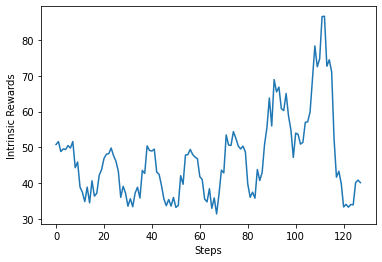

=== Rollout num. 1 ================================
[]


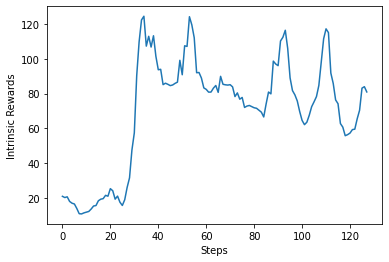

=== Rollout num. 2 ================================
[17]


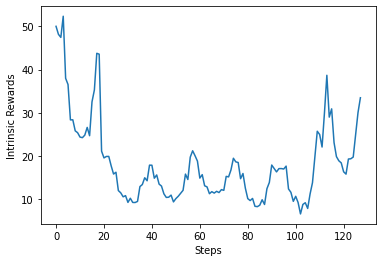

=== Rollout num. 3 ================================
[38, 60]


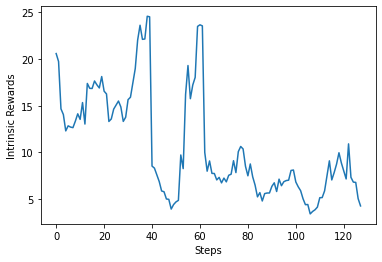

=== Rollout num. 4 ================================
[81]


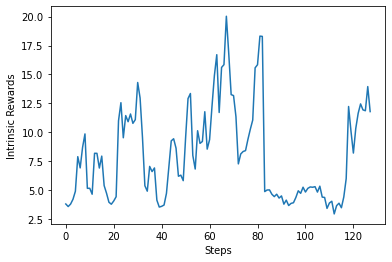

=== Rollout num. 5 ================================
[94]


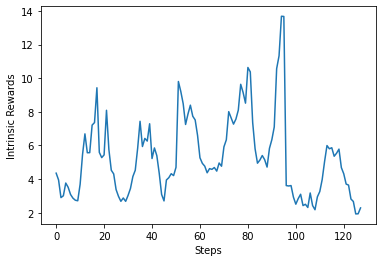

=== Rollout num. 6 ================================
[38]


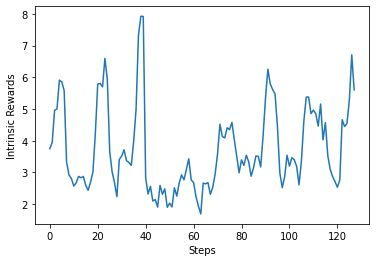

=== Rollout num. 7 ================================
[0, 55, 96]


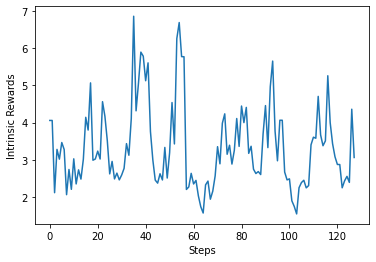

=== Rollout num. 8 ================================
[1]


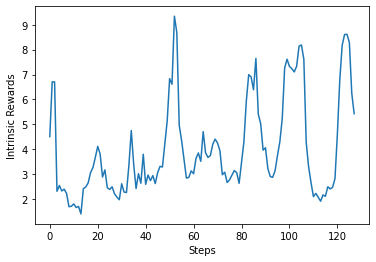

=== Rollout num. 9 ================================
[26]


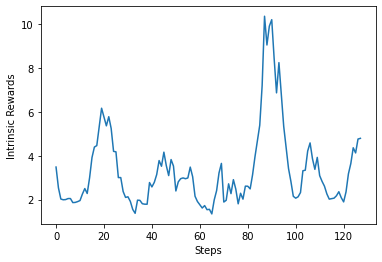

=== Rollout num. 10 ================================
[11, 42, 91]


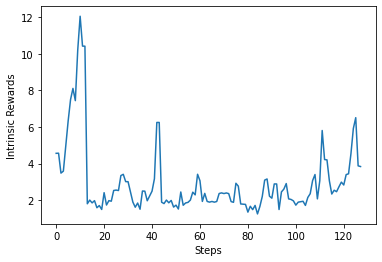

=== Rollout num. 11 ================================
[26, 59, 78, 97]


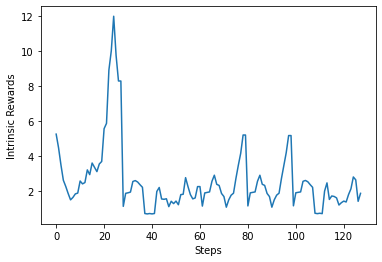

=== Rollout num. 12 ================================
[86]


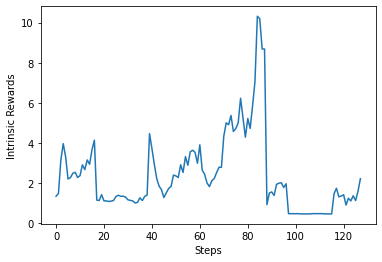

=== Rollout num. 13 ================================
[4]


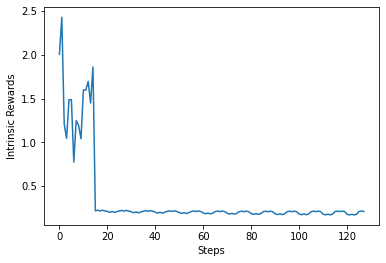

=== Rollout num. 14 ================================
[]


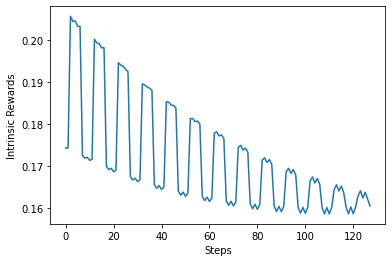

In [8]:
for i in range(len(intrinsic_rewards)):
    print("=== Rollout num. {} ================================".format(i))
    print(last_episode_step[i])

    steps = range(len(intrinsic_rewards[i])) #N_STEPS)#N_EPOCHS)

    plt.plot(steps, intrinsic_rewards[i])

    plt.xlabel("Steps")
    plt.ylabel("Intrinsic Rewards")

    plt.show()